# Exploratory Analysis

Here, we do some basic munging and analysis of the raw USHCN precipitation data. 

In [1]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk')

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader

The data was preprocessed and saved, compressed in an HDF5 file with two records:

1. `/precip`: Precipitation data, with each column corresponding to a station, forming a table of Series indexed by date of observation.
2. `/stations`: Table with station metadata, indexed by the same **station_id** as `/precip`

In [2]:
store = pd.HDFStore("proc/USHCNprecip.h5")
print(store)
precip = store['precip']
stations = store['stations']
store.close()

<class 'pandas.io.pytables.HDFStore'>
File path: proc/USHCNprecip.h5
/precip              frame        (shape->[41975,1218])
/stations            frame        (shape->[1218,4])    


## Station averages - 2010-2014

Re-producing John's observation about the too-large values in the final decadal averages for some stations.

In [13]:
decade_df = (
    precip
    .loc[pd.IndexSlice["2010-01-01":]]
    .mean(skipna=True)
)
decade_df.name = 'precip'

print(decade_df.describe())

count    1100.000000
mean        9.860253
std         9.301270
min         0.000000
25%         5.405949
50%         9.977526
75%        12.861979
max       220.000000
Name: precip, dtype: float64


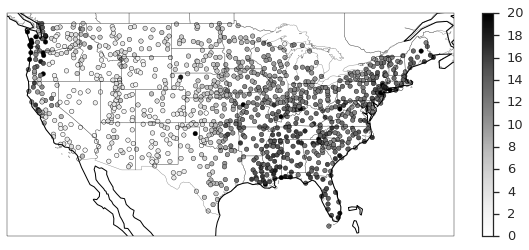

In [16]:
import matplotlib.colors as cm
from util import add_usa_boundaries

df = pd.concat([stations, decade_df], axis=1)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, projection=proj,
                     aspect='auto')
ax = add_usa_boundaries(ax, proj)

norm = cm.Normalize(0, 20.)

s = ax.scatter(df.lon, df.lat, c=df.precip, norm=norm)
cb = fig.colorbar(s)

---

Where were the very large, outlier data points coming from?

In [7]:
outliers = decade_df.loc[decade_df > 100.]
stations.loc[outliers.index]

,elev,lon,lat,station_name
station_id,,,,
280,173.7,-85.785004,38.688599,"SCOTTSBURG, IN, 127875"
515,251.5,-93.855003,39.182800,"LEXINGTON 3E, MO, 234904"


In [20]:
last_decade = precip.loc[pd.IndexSlice["2010-01-01":], 
                         outliers.index]
df = pd.melt(last_decade)
print("counts", df.groupby('station_id').count())

('counts',             value
station_id       
280             1
515             1)


(730120.0, 735598.0)

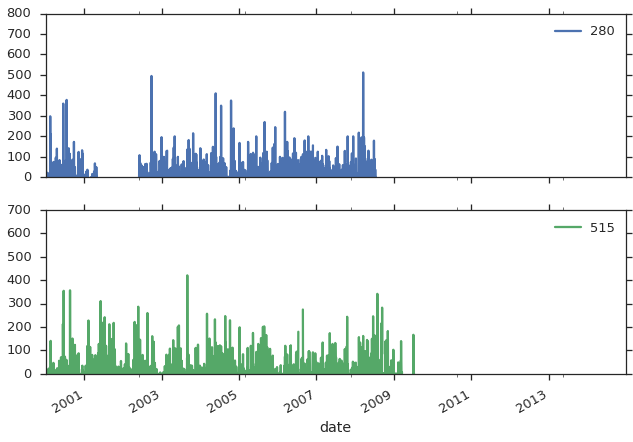

In [9]:
from datetime import date

axes = precip.loc[pd.IndexSlice[:], outliers.index].plot(subplots=True, sharex=True)
ax = axes[0]
ax.set_xlim(date(2000, 1, 1))